In [3]:
import tensorflow as tf
from tensorflow import keras
from keras import datasets

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

print('x_train.shape =',x_train.shape)
print('y_train.shape =',y_train.shape)
print('x_test.shape =',x_test.shape)
print('y_test.shape =',y_test.shape)


4431872/4422102 [==============================] - 0s 0us/step
x_train.shape = (60000, 28, 28)
y_train.shape = (60000,)
x_test.shape = (10000, 28, 28)
y_test.shape = (10000,)


In [4]:
import numpy as np

num_classes = np.unique(y_test).shape[0]
print('num_classes =', num_classes)


num_classes = 10


In [5]:
x_train_norm = x_train/255
x_test_norm = x_test/255


In [6]:
final_train_imageset = np.expand_dims(x_train_norm, axis = 3)
final_test_imageset = np.expand_dims(x_test_norm, axis = 3)

y_train2 = np.expand_dims(y_train, axis = 1)
y_test2 = np.expand_dims(y_test, axis = 1)

print('final_train_imageset.shape =', final_train_imageset.shape)
print('final_test_imageset.shape =', final_test_imageset.shape)
print('y_train2.shape =', y_train2.shape)
print('y_test2.shape =', y_test2.shape)


final_train_imageset.shape = (60000, 28, 28, 1)
final_test_imageset.shape = (10000, 28, 28, 1)
y_train2.shape = (60000, 1)
y_test2.shape = (10000, 1)


In [7]:
final_train_label = keras.utils.to_categorical(y_train2, num_classes)
final_test_label = keras.utils.to_categorical(y_test2, num_classes)

print('final_train_label.shape =',final_train_label.shape)
print('final_test_label.shape =',final_test_label.shape)


final_train_label.shape = (60000, 10)
final_test_label.shape = (10000, 10)


In [16]:
percentile = 1.0 # 1.0, 0.5, 0.1, 0.01

NUM_NEURONS = (x_train.shape[1]*x_train.shape[2])*percentile
NUM_LAYERS = 1
BATCH_SIZE = 128
NUM_EPOCHS = 100
LEARNING_RATE = 0.0001
EPSILON = 1e-4
DROPOUT = 0.5 # 0.5, 0.8

LOSS = 'categorical_crossentropy'
DENSE_ACTIVATION_FUNCTION = 'relu' 
FINAL_ACTIVATION_FUNCTION = 'softmax'
early_stop_after_epochs = 50 # stop after 50 consecutive epochs with no improvement
validation_split = 0.1

checkpointer_name = "weights.Dense.Fashion.nLayers"+str(NUM_LAYERS)+".nNeurons"+str(NUM_NEURONS)+".act."+DENSE_ACTIVATION_FUNCTION+".p"+str(percentile)+".dropout"+str(DROPOUT)+".batch"+str(BATCH_SIZE)+".hdf5"


In [17]:
from keras.layers import *
from keras.models import * #Model, load_model#

input_shape = final_train_imageset.shape[1:]

# Input tensor shape
inputs = Input(input_shape)

x = inputs
for _ in range(NUM_LAYERS):
    x = Dense(NUM_NEURONS, activation=DENSE_ACTIVATION_FUNCTION)(x)
    x = Dropout(DROPOUT)(x)

x = Flatten()(x)
outputs = Dense(num_classes, activation=FINAL_ACTIVATION_FUNCTION)(x)

model = Model(inputs=inputs, outputs=outputs)
model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 dense_2 (Dense)             (None, 28, 28, 784)       1568      
                                                                 
 dropout_1 (Dropout)         (None, 28, 28, 784)       0         
                                                                 
 flatten_1 (Flatten)         (None, 614656)            0         
                                                                 
 dense_3 (Dense)             (None, 10)                6146570   
                                                                 
Total params: 6,148,138
Trainable params: 6,148,138
Non-trainable params: 0
_________________________________________________________________


In [18]:
model.compile(
    optimizer='Adam',
    loss=LOSS,
    metrics=['accuracy', 'Precision', 'Recall']
)


In [19]:
### Set model checkpointer

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

checkpointer_best = ModelCheckpoint(filepath = checkpointer_name, 
                                    monitor='val_loss', 
                                    save_weights_only=False,
                                    mode='auto',  
                                    verbose = 2, 
                                    save_best_only = True
                                    )
                                    
early_stopping = EarlyStopping(monitor='val_loss', patience=early_stop_after_epochs)


In [20]:
### train the model

list_callbacks = [checkpointer_best, early_stopping]

history = model.fit(final_train_imageset, final_train_label, 
                        shuffle=True, 
                        batch_size = BATCH_SIZE, 
                        epochs = NUM_EPOCHS,
                        validation_split = validation_split,
                        callbacks=list_callbacks
                    )


Epoch 1/100
422/422 [==============================] - ETA: 0s - loss: 0.5625 - accuracy: 0.8049 - precision: 0.8546 - recall: 0.7539
Epoch 1: val_loss improved from inf to 0.50773, saving model to weights.Dense.Fashion.nLayers1.nNeurons784.0.act.relu.p1.0.dropout0.5.batch128.hdf5
422/422 [==============================] - 28s 65ms/step - loss: 0.5625 - accuracy: 0.8049 - precision: 0.8546 - recall: 0.7539 - val_loss: 0.5077 - val_accuracy: 0.8133 - val_precision: 0.8518 - val_recall: 0.7722
Epoch 2/100
422/422 [==============================] - ETA: 0s - loss: 0.4596 - accuracy: 0.8414 - precision: 0.8750 - recall: 0.8063
Epoch 2: val_loss improved from 0.50773 to 0.42182, saving model to weights.Dense.Fashion.nLayers1.nNeurons784.0.act.relu.p1.0.dropout0.5.batch128.hdf5
422/422 [==============================] - 27s 63ms/step - loss: 0.4596 - accuracy: 0.8414 - precision: 0.8750 - recall: 0.8063 - val_loss: 0.4218 - val_accuracy: 0.8530 - val_precision: 0.8883 - val_recall: 0.8155
Ep

In [21]:
### load the trained model and evaluate using the test set

model_loaded = load_model(checkpointer_name)
result = model_loaded.evaluate(final_test_imageset, final_test_label)


313/313 [==============================] - 3s 8ms/step - loss: 0.3817 - accuracy: 0.8672 - precision: 0.8883 - recall: 0.8530


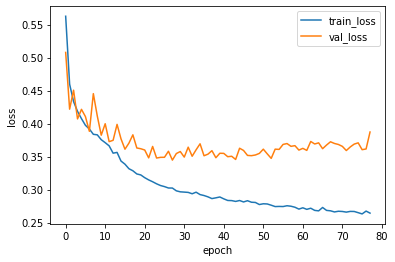

In [23]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
#plt.title(title)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'], loc = 'best')


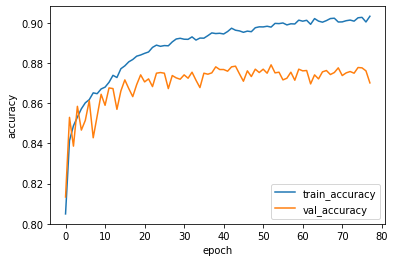

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
#plt.title(title)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy','val_accuracy'], loc = 'best')


In [ ]:
### loss: 0.3817 - accuracy: 0.8672 - precision: 0.8883 - recall: 0.8530S